## Импорт необходимых библиотек

In [38]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import numpy as np
import importlib
import matplotlib.pyplot as plt
import random
import segmentation_models_pytorch as smp
import torchvision.models as models
from utils import functions
from models import linknet
importlib.reload(functions)
importlib.reload(linknet)

<module 'models.linknet' from 'C:\\Users\\Raindow\\Desktop\\СПБГУ\\models\\linknet.py'>

## Конфигурация PyTorch

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA devices: {torch.cuda.device_count()}")
print(f"Current CUDA device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA devices: 1
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 4070


## Конфигурация модели

In [40]:
# Конфигурация
DATA_PATH = "dataset"
BATCH_SIZE = 16
EPOCHS = 100
LR = 0.001
IMG_SIZE = 256

## Класс, описывающий датасет

In [41]:
# Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        
        self.empty_indices = []
        self.non_empty_indices = []
        
        for idx, img_name in enumerate(self.images):
            mask_path = os.path.join(self.mask_dir, img_name)
            mask = np.array(Image.open(mask_path).convert("L"))
            if np.all(mask == 0):
                self.empty_indices.append(idx)
            else:
                self.non_empty_indices.append(idx)
        
        print(f"Total: {len(self.images)} images")
        print(f"Mask statistics: {len(self.empty_indices)} empty, {len(self.non_empty_indices)} non-empty")
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

## Аугментация данных

In [42]:
# Аугментация
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
])


## Загрузка датасета

In [43]:
# Загрузка полного датасета
full_dataset = SegmentationDataset(
    image_dir=os.path.join(DATA_PATH, "images"),
    mask_dir=os.path.join(DATA_PATH, "masks"),
    transform=transform
)

Total: 17408 images
Mask statistics: 13435 empty, 3973 non-empty


## Балансировка классов

In [44]:
# Создание сбалансированного списка индексов
empty = full_dataset.empty_indices
non_empty = full_dataset.non_empty_indices
random.shuffle(empty)
random.shuffle(non_empty)

min_count = min(len(empty), len(non_empty))
balanced_indices = empty + non_empty
random.shuffle(balanced_indices)

## Разделение на обучающую и тестовую выборку, загрузка данных

In [45]:
# Разделение на обучающую и тестовую выборку
split_idx = int(0.8 * len(balanced_indices))
train_indices = balanced_indices[:split_idx]
test_indices = balanced_indices[split_idx:]

train_subset = Subset(full_dataset, train_indices)
test_subset = Subset(full_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE)

## Обучение модели LinkNet

In [46]:
# Создаем модель с дополнительными слоями
print(device)

model = linknet.LinkNet(num_classes=1, in_channels=3).to(device)

modified_model = model.to(device)
pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(modified_model.parameters(), lr=LR, weight_decay=1e-5)

train_losses, test_losses, ious, dices = [], [], [], []
best_iou = -1

for epoch in range(EPOCHS):
    modified_model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = modified_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    modified_model.eval()
    test_loss = 0
    epoch_ious, epoch_dices = [], []
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = modified_model(images)
            test_loss += criterion(outputs, masks).item()
            batch_iou, batch_dice = functions.calculate_metrics(outputs, masks)
            epoch_ious.append(batch_iou)
            epoch_dices.append(batch_dice)

    avg_iou = np.mean(epoch_ious)
    avg_dice = np.mean(epoch_dices)
    avg_test_loss = test_loss / len(test_loader)

    train_losses.append(epoch_loss / len(train_loader))
    test_losses.append(avg_test_loss)
    ious.append(avg_iou)
    dices.append(avg_dice)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}")
    print(f"IoU: {ious[-1]:.4f} | Dice: {dices[-1]:.4f}")
    print("------------------------")
    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(modified_model.state_dict(), "Linknet_final.pth")
        print(f"Best modified_model saved at epoch {epoch+1} with IoU: {avg_iou:.4f}")

cuda


C:\Users\Raindow\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Raindow\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100
Train Loss: 0.4772 | Test Loss: 0.5546
IoU: 0.7641 | Dice: 0.7641
------------------------
Best modified_model saved at epoch 1 with IoU: 0.7641
Epoch 2/100
Train Loss: 0.4539 | Test Loss: 0.4553
IoU: 0.6990 | Dice: 0.7073
------------------------
Epoch 3/100
Train Loss: 0.4505 | Test Loss: 0.4404
IoU: 0.7220 | Dice: 0.7246
------------------------
Epoch 4/100
Train Loss: 0.4427 | Test Loss: 0.4392
IoU: 0.7641 | Dice: 0.7641
------------------------
Epoch 5/100
Train Loss: 0.4416 | Test Loss: 0.4433
IoU: 0.7641 | Dice: 0.7641
------------------------
Epoch 6/100
Train Loss: 0.4414 | Test Loss: 0.4552
IoU: 0.7462 | Dice: 0.7464
------------------------
Epoch 7/100
Train Loss: 0.4354 | Test Loss: 0.4737
IoU: 0.7607 | Dice: 0.7607
------------------------
Epoch 8/100
Train Loss: 0.4366 | Test Loss: 0.4339
IoU: 0.7069 | Dice: 0.7134
------------------------
Epoch 9/100
Train Loss: 0.4362 | Test Loss: 0.5893
IoU: 0.7641 | Dice: 0.7641
------------------------
Epoch 10/100
Train 

## Метрики

## Test/train losses

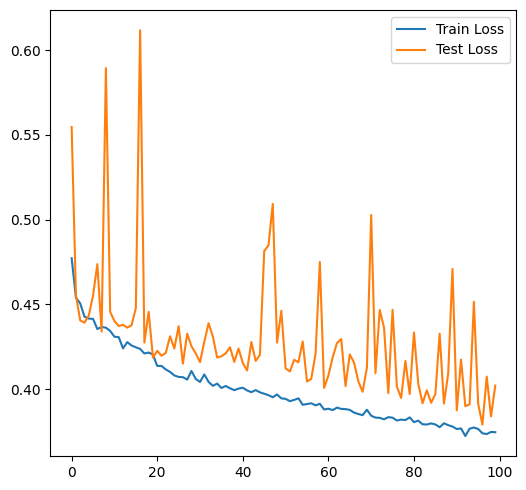

In [47]:
# Графики
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.tight_layout()
plt.show()

## IoU

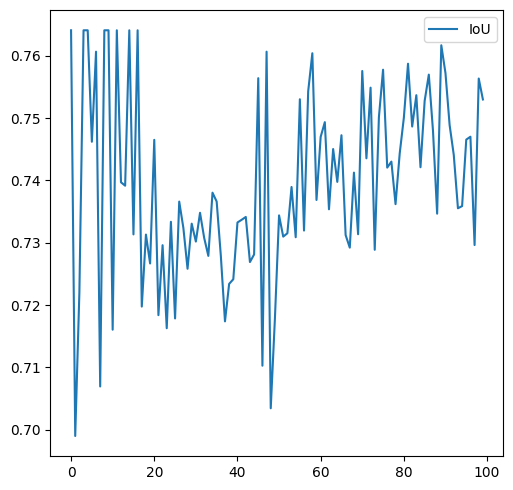

In [48]:
plt.figure(figsize=(15, 5))
plt.subplot(132)
plt.plot(ious, label='IoU')
plt.legend()
plt.tight_layout()
plt.show()

## Dice coef

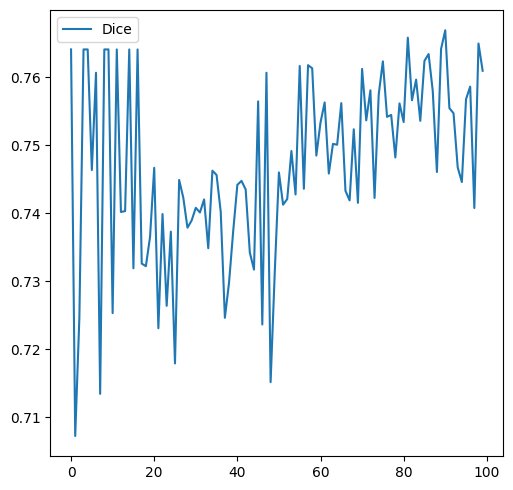

In [49]:
plt.figure(figsize=(15, 5))
plt.subplot(133)
plt.plot(dices, label='Dice')
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
torch.save(model.state_dict(), "Linknet_final.pth")